Los objetivos de este análisis son:
* Identificar el tipo de dato de todas la entidades en la tabla.
* Estadísticas generales (conteo de registros, mínimo, máximo, datos nulos, etc.)
* Conocer la longitud máxima de cadena para cada entidad.
* Identificar y corregir problemas en los datos.
* Identificar llaves primarias y foráneas.

In [28]:
# Librerías
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

* Se encontró el mensaje: "Error tokenizing data. C error: Expected 29 fields in line 244, saw 30" al leer los datos como un DataFrame para CUSTOMERt, PRODUCTSt y PROMOTION. Esto se debe a que hay filas con mayor cantidad de datos que los encabezados de columna.
* Al revisar los datos en CSV, existen descripciones que emplean comas(,). Se procedió a reemplazar los casos ", " por ("; ").
* Adicionalmente, PRODUCTSt en la línea en el Product Key 477 hacía uso de una coma para indicar decimales y se reemplazó "0," por "0.".

In [29]:
# myPath = '/workspaces/Database-project/data/aligned/'
# # CUSTOMERS
# custFile = open(myPath + "CUSTOMERt.csv", "r", encoding='latin-1')
# text = ''.join([i for i in custFile]) \
#     .replace(", ", "; ")
# x = open(myPath + "CUSTOMERt_aligned.csv","w", encoding='latin-1')
# x.writelines(text)
# x.close()
# # PRODUCTS
# prodFile = open(myPath + "PRODUCTSt.csv", "r", encoding='latin-1')
# text = ''.join([i for i in prodFile]) \
#     .replace(", ", "; ").replace("0,", "0.")
# x = open(myPath + "PRODUCTSt_aligned.csv","w", encoding='latin-1')
# x.writelines(text)
# x.close()
# # PROMOTION
# prom_file = open(myPath + "PROMOTION.csv", "r", encoding='latin-1')
# text = ''.join([i for i in prom_file]) \
#     .replace(", ", "; ")
# x = open(myPath + "PROMOTION_aligned.csv","w", encoding='latin-1')
# x.writelines(text)
# x.close()

# Lectura de datos
myPath = '/workspaces/Database-project/data/'
# Principales
sales = pd.read_csv(myPath + 'SALES.csv', encoding='latin-1')
cust = pd.read_csv(myPath + 'aligned/CUSTOMERt_aligned.csv', encoding='latin-1')
prod = pd.read_csv(myPath + 'aligned/PRODUCTSt_aligned.csv', encoding='latin-1')
# Complementarios
prom = pd.read_csv(myPath + 'aligned/PROMOTION_aligned.csv', encoding='latin-1')
curr = pd.read_csv(myPath + 'CURRENCY.csv', encoding='latin-1')


## 1. Sales
Preguntas planteadas al tener una visualización general:
1. ¿Son útiles las columnas OrderDateKey, ShipDateKey y CustomerKey?
2. ¿Son nulos todos los datos en CarrierTrackingNumber y CustomerPONumber?
3. ¿Cuál es la función del identificador SalesOrderNumber?
4. ¿Existen registros nulos en alguna otra columna?
5. ¿SalesTerritoryKey es llave primaria de otra tabla?

In [30]:
# sales.info() # 60398 entries, 26 columns
sales.head(3)

ProductKey  OrderDateKey  DueDateKey  ShipDateKey  CustomerKey  \
0         310      20101229    20110110     20110105        21768   
1         346      20101229    20110110     20110105        28389   
2         346      20101229    20110110     20110105        25863   

   PromotionKey  CurrencyKey  SalesTerritoryKey SalesOrderNumber  \
0             1           19                  6          SO43697   
1             1           39                  7          SO43698   
2             1          100                  1          SO43699   

   SalesOrderLineNumber  ...  ProductStandardCost  TotalProductCost  \
0                     1  ...            2171.2942         2171.2942   
1                     1  ...            1912.1544         1912.1544   
2                     1  ...            1912.1544         1912.1544   

   SalesAmount    TaxAmt  Freight  CarrierTrackingNumber  CustomerPONumber  \
0      3578.27  286.2616  89.4568                    NaN               NaN   
1      3399.99  271.9992  84.9998                    NaN               NaN   
2      3399.99  271.9992  84.9998                    NaN               NaN   

             OrderDate              DueDate             ShipDate  
0  2010-12-29 00:00:00  2011-01-10 00:00:00  2011-01-05 00:00:00  
1  2010-12-29 00:00:00  2011-01-10 00:00:00  2011-01-05 00:00:00  
2  2010-12-29 00:00:00  2011-01-10 00:00:00  2011-01-05 00:00:00  

[3 rows x 26 columns]

### Modificaciones en la tabla sales
* SalesOrderNumber contiene una cantidad de registros mucho menor y se concluye que es de utilidad para realizar agrupaciones.
* Se eliminan las columnas sin datos (CarrierTrackingNumber, CustomerPONumber) y las "llaves" de fechas (YYYYMMDD).
* Se remueven las columnas para las que se repite un mismo valor en todas las filas.
    * RevisionNumber y OrderQuantity tienen 1 como su único valor.
    * UnitPriceDiscountPct y DiscountAmount tienen 0 como su único valor.

In [31]:
sales[['CarrierTrackingNumber', 'CustomerPONumber', \
        'RevisionNumber', 'OrderQuantity', 'UnitPriceDiscountPct', 'DiscountAmount']].describe().T

count  mean  std  min  25%  50%  75%  max
CarrierTrackingNumber      0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
CustomerPONumber           0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
RevisionNumber         60398.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
OrderQuantity          60398.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
UnitPriceDiscountPct   60398.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
DiscountAmount         60398.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [32]:
# Se verifica que ninguna fecha tenga problemasde formato.
sales['OrderDate'] = pd.to_datetime(sales['OrderDate'], format='%Y-%m-%d %H:%M:%S')
sales['DueDate'] = pd.to_datetime(sales['DueDate'], format='%Y-%m-%d %H:%M:%S')
sales['ShipDate'] = pd.to_datetime(sales['ShipDate'], format='%Y-%m-%d %H:%M:%S')

# sales['SalesOrderNumber'].unique().shape # (27659,) << 60398
# Se eliminan las columnas sin datos y las llaves de fechas.
sales.drop(columns=['CarrierTrackingNumber', 'CustomerPONumber', \
    'OrderDateKey', 'DueDateKey', 'ShipDateKey', \
        'RevisionNumber', 'OrderQuantity', 'UnitPriceDiscountPct', 'DiscountAmount'], inplace = True)
# Guardamos los datos limpios.
sales.to_csv(myPath+'cleaned/SALES_clean.csv', index=False)
sales.describe().T

count          mean          std         min  \
ProductKey            60398.0    437.557932   118.088390    214.0000   
CustomerKey           60398.0  18841.685420  5432.430404  11000.0000   
PromotionKey          60398.0      1.041839     0.342605      1.0000   
CurrencyKey           60398.0     69.845326    42.146363      6.0000   
SalesTerritoryKey     60398.0      6.244462     2.961150      1.0000   
SalesOrderLineNumber  60398.0      1.886321     1.016328      1.0000   
UnitPrice             60398.0    486.086911   928.489892      2.2900   
ExtendedAmount        60398.0    486.086911   928.489892      2.2900   
ProductStandardCost   60398.0    286.065657   552.457641      0.8565   
TotalProductCost      60398.0    286.065657   552.457641      0.8565   
SalesAmount           60398.0    486.086911   928.489892      2.2900   
TaxAmt                60398.0     38.886954    74.279193      0.1832   
Freight               60398.0     12.152217    23.212248      0.0573   

                             25%         50%         75%         max  
ProductKey              359.0000    479.0000    529.0000    606.0000  
CustomerKey           14003.0000  18143.0000  23429.7500  29483.0000  
PromotionKey              1.0000      1.0000      1.0000     14.0000  
CurrencyKey              19.0000    100.0000    100.0000    100.0000  
SalesTerritoryKey         4.0000      7.0000      9.0000     10.0000  
SalesOrderLineNumber      1.0000      2.0000      2.0000      8.0000  
UnitPrice                 7.9500     29.9900    539.9900   3578.2700  
ExtendedAmount            7.9500     29.9900    539.9900   3578.2700  
ProductStandardCost       2.9733     11.2163    294.5797   2171.2942  
TotalProductCost          2.9733     11.2163    294.5797   2171.2942  
SalesAmount               7.9500     29.9900    539.9900   3578.2700  
TaxAmt                    0.6360      2.3992     43.1992    286.2616  
Freight                   0.1988      0.7498     13.4998     89.4568

La descripción de los datos nos da indicios sobre nuestros datos categóricos:
* PromotionKey
* SalesTerritoryKey
* SalesOrderLineNumber

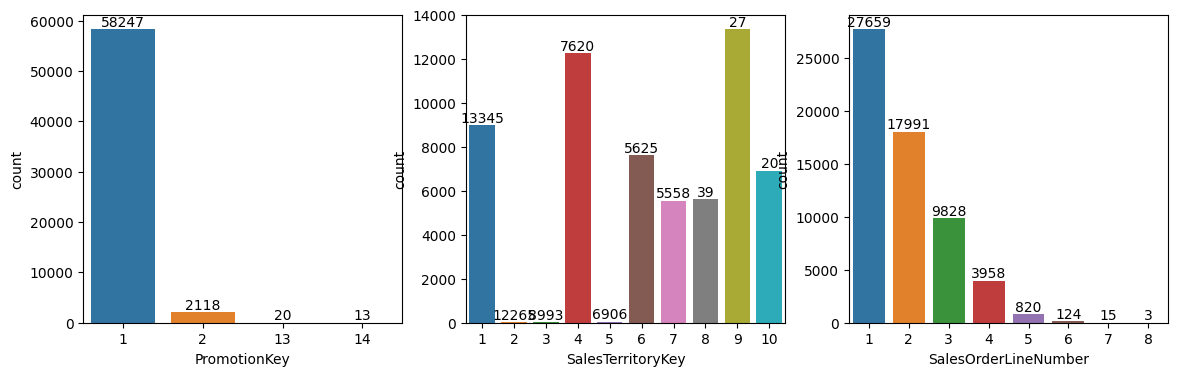

In [33]:
sales = pd.read_csv(myPath + 'cleaned/SALES_clean.csv', encoding='latin-1', \
    parse_dates=['OrderDate', 'DueDate', 'ShipDate'], infer_datetime_format=True)
df = sales
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = sns.countplot(data = df, ax=axes[0], x='PromotionKey')
abs_values = df['PromotionKey'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax = sns.countplot(data= df, ax=axes[1], x='SalesTerritoryKey')
abs_values = df['SalesTerritoryKey'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax = sns.countplot(ax=axes[2], x=df['SalesOrderLineNumber'])
abs_values = df['SalesOrderLineNumber'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values);

* Finalmente, concluimos con 9 columnas menos.
* Obtenemos el tipo de dato y número de caracteres de las columnas.
* Se identifican 5 llaves que contienen "Key" en su nombre.
    * ProductKey
    * CustomerKey
    * PromotionKey
    * CurrencyKey
    * SalesTerritoryKey

In [34]:
num_types = sales.dtypes.to_frame('dtypes')
min_col_len = sales.round(1).astype(str).apply(lambda s: s.str.len()).min().to_frame('min_length')
max_col_len = sales.round(1).astype(str).apply(lambda s: s.str.len()).max().to_frame('max_length')
min_max_value = sales.describe().T[['min','max']].round(1)
my_summary = pd.concat([num_types, min_col_len, max_col_len, min_max_value], axis=1)
sales_serie = sales['SalesOrderNumber'].str[2:]
# En SalesOrderNumber se ordenan los datos omitiendo 'CO'
min = 'CO'+ str(pd.to_numeric(sales_serie).min())
max = 'CO'+ str(pd.to_numeric(sales_serie).max())
dates = sales[['OrderDate','DueDate','ShipDate']]
my_summary.loc['SalesOrderNumber', ['min','max']] = [min, max]
my_summary.loc[['OrderDate','DueDate','ShipDate'], 'min'] = dates.min()
my_summary.loc[['OrderDate','DueDate','ShipDate'], 'max'] = dates.max()
my_summary

dtypes  min_length  max_length  \
ProductKey                     int64           3           3   
CustomerKey                    int64           5           5   
PromotionKey                   int64           1           2   
CurrencyKey                    int64           1           3   
SalesTerritoryKey              int64           1           2   
SalesOrderNumber              object           7           7   
SalesOrderLineNumber           int64           1           1   
UnitPrice                    float64           3           6   
ExtendedAmount               float64           3           6   
ProductStandardCost          float64           3           6   
TotalProductCost             float64           3           6   
SalesAmount                  float64           3           6   
TaxAmt                       float64           3           5   
Freight                      float64           3           4   
OrderDate             datetime64[ns]          10          10   
DueDate               datetime64[ns]          10          10   
ShipDate              datetime64[ns]          10          10   

                                      min                  max  
ProductKey                          214.0                606.0  
CustomerKey                       11000.0              29483.0  
PromotionKey                          1.0                 14.0  
CurrencyKey                           6.0                100.0  
SalesTerritoryKey                     1.0                 10.0  
SalesOrderNumber                  CO43697              CO75123  
SalesOrderLineNumber                  1.0                  8.0  
UnitPrice                             2.3               3578.3  
ExtendedAmount                        2.3               3578.3  
ProductStandardCost                   0.9               2171.3  
TotalProductCost                      0.9               2171.3  
SalesAmount                           2.3               3578.3  
TaxAmt                                0.2                286.3  
Freight                               0.1                 89.5  
OrderDate             2010-12-29 00:00:00  2014-01-28 00:00:00  
DueDate               2011-01-10 00:00:00  2014-02-09 00:00:00  
ShipDate              2011-01-05 00:00:00  2014-02-04 00:00:00

## 2. CUSTOMERS
Preguntas de la visualización general:
* ¿Es de utilidad una llave alterna de CustomerKey?
* ¿Qué información aporta NameStyle (solo existen valores falsos y nulos)?
* ¿Los primeros dígitos en AddressLine1 son el código postal?
* ¿Los números de teléfono con más de 10 dígitos añadieron al principio LADA?
* ¿CommuteDistance es la distancia de los clientes al punto de venta?

In [35]:
# cust.info() #18485 entradas, 29 columnas
cust.head(4)

CustomerKey  GeographyKey CustomerAlternateKey Title FirstName MiddleName  \
0        11000            26           AW00011000   NaN       Jon          V   
1        11001            37           AW00011001   NaN    Eugene          L   
2        11002            31           AW00011002   NaN     Ruben        NaN   
3         1002            31           AW00011002   NaN       NaN        NaN   

  LastName NameStyle   BirthDate MaritalStatus  ... EnglishOccupation  \
0     Yang     False  1971-10-06             M  ...      Professional   
1    Huang     False  1976-05-10             S  ...      Professional   
2   Torres     False  1971-02-09             M  ...               NaN   
3      NaN       NaN         NaN           NaN  ...      Professional   

  SpanishOccupation FrenchOccupation  HouseOwnerFlag  NumberCarsOwned  \
0       Profesional            Cadre             1.0              0.0   
1       Profesional            Cadre             0.0              1.0   
2               NaN            Cadre             1.0              1.0   
3       Profesional              NaN             NaN              NaN   

       AddressLine1 AddressLine2                Phone DateFirstPurchase  \
0   3761 N. 14th St          NaN  1 (11) 500 555-0162        2011-01-19   
1        2243 W St.          NaN  1 (11) 500 555-0110        2011-01-15   
2  5844 Linden Land          NaN  1 (11) 500 555-0184        2011-01-07   
3               NaN          NaN                  NaN               NaN   

  CommuteDistance  
0       1-2 Miles  
1       0-1 Miles  
2       2-5 Miles  
3             NaN  

[4 rows x 29 columns]

## Modificaciones en la tabla customers
* El cuarto registro en la tabla es un duplicado del tercero, con información complementaria. Hay que fusionar esa información.
* El 1 (11) en la columna Phone, parece ser información repetitiva. El formato de número deberá ser forzosamente XXX-XXX-XXXX, o bien 10 dígitos seguidos.
* La palabra "Miles" en la columna CommuteDistance es información redundante. Se debe eliminar. Además, contiene información categórica (0-1,2-5...), que puede ser mapeada con números para disminuir el volumen de datos.
* BirthDate y DateFirstPurchase deben guardarse en formato de fecha.
* Title contiene colamente 101 registros, Suffix 3 y AddressLine2 312. Considerando que el total de registros es de 18485, estas columnas tienen un porcentaje de datos del 0.54, 0.016 y 1.7%, respectivamente, por lo que las columnas no generarán conocimientos de interés y se eliminarán.

## Tabla products
* Se encontro que para la tabla Products_clean cuenta con 606 registros los cuales en su mayoria son de tipo object que en sql seria varchar.

In [36]:
#Cargamos archivo csv
products=pd.read_csv('/workspaces/Database-project/data/cleaned/Products_Clean.csv', encoding='utf-8')

In [37]:
types=products.dtypes.to_frame('dtypes')
min_col_len=products.round(1).astype(str).apply(lambda s: s.str.len()).min().to_frame('min_length')
max_col_len=products.round(1).astype(str).apply(lambda s: s.str.len()).max().to_frame('max_length')
min_max_value=products.describe().T[['min','max']].round(1)
my_summary=pd.concat([types,min_col_len,max_col_len,min_max_value], axis=1)
my_summary



dtypes  min_length  max_length  min     max
ProductKey               int64           1           3  1.0   606.0
ProductAlternateKey     object           7          10  NaN     NaN
ProductSubcategoryKey  float64           3           4  1.0    37.0
WeightUnitMeasureCode   object           3           3  NaN     NaN
SizeUnitMeasureCode     object           3           3  NaN     NaN
EnglishProductName      object           4          32  NaN     NaN
SpanishProductName      object           3          47  NaN     NaN
FrenchProductName       object           3          46  NaN     NaN
StandardCost           float64           3           6  0.9  2171.3
FinishedGoodsFlag         bool           4           5  NaN     NaN
Color                   object           3          12  NaN     NaN
SafetyStockLevel         int64           1           4  4.0  1000.0
ReorderPoint             int64           1           3  3.0   750.0
ListPrice              float64           3           6  2.3  3578.3
Size                    object           1           3  NaN     NaN
SizeRange               object           1           8  NaN     NaN
Weight                 float64           3           6  2.1  1050.0
DaysToManufacture        int64           1           1  0.0     4.0
ProductLine             object           2           3  NaN     NaN
DealerPrice            float64           3           6  1.4  2147.0
Class                   object           2           3  NaN     NaN
Style                   object           2           3  NaN     NaN
ModelName               object           3          27  NaN     NaN
EnglishDescription      object           3         221  NaN     NaN
FrenchDescription       object           3         269  NaN     NaN
StartDate               object          16          16  NaN     NaN
EndDate                 object           3          16  NaN     NaN
Status                  object           3           7  NaN     NaN

In [38]:
#Visulizamos una descripción de los datos que son numéricos
products.describe().T

count        mean         std     min       25%  \
ProductKey             606.0  303.500000  175.081410  1.0000  152.2500   
ProductSubcategoryKey  397.0   12.128463    9.423328  1.0000    2.0000   
StandardCost           395.0  434.265829  497.379884  0.8565   37.1209   
SafetyStockLevel       606.0  495.201320  364.007114  4.0000  100.0000   
ReorderPoint           606.0  371.400990  273.005336  3.0000   75.0000   
ListPrice              395.0  747.661762  838.708451  2.2900   69.9900   
Weight                 282.0   56.193227  158.000652  2.1200    2.6800   
DaysToManufacture      606.0    1.201320    1.508893  0.0000    0.0000   
DealerPrice            395.0  448.597060  503.225071  1.3740   41.9940   

                            50%        75%        max  
ProductKey             303.5000   454.7500   606.0000  
ProductSubcategoryKey   13.0000    16.0000    37.0000  
StandardCost           204.6251   660.9142  2171.2942  
SafetyStockLevel       500.0000  1000.0000  1000.0000  
ReorderPoint           375.0000   750.0000   750.0000  
ListPrice              364.0900  1204.3248  3578.2700  
Weight                  15.4200    24.1300  1050.0000  
DaysToManufacture        1.0000     1.0000     4.0000  
DealerPrice            218.4540   722.5949  2146.9620

In [39]:
products.head(7)

ProductKey ProductAlternateKey  ProductSubcategoryKey  \
0           1             AR-5381                    NaN   
1           2             BA-8327                    NaN   
2           3             BE-2349                    NaN   
3           4             BE-2908                    NaN   
4           5             BL-2036                    NaN   
5           6             CA-5965                    NaN   
6           7             CA-6738                    NaN   

  WeightUnitMeasureCode SizeUnitMeasureCode     EnglishProductName  \
0                   NaN                 NaN        Adjustable Race   
1                   NaN                 NaN           Bearing Ball   
2                   NaN                 NaN        BB Ball Bearing   
3                   NaN                 NaN  Headset Ball Bearings   
4                   NaN                 NaN                  Blade   
5                   NaN                 NaN            LL Crankarm   
6                   NaN                 NaN            ML Crankarm   

  SpanishProductName FrenchProductName  StandardCost  FinishedGoodsFlag  ...  \
0                NaN               NaN           NaN              False  ...   
1                NaN               NaN           NaN              False  ...   
2                NaN               NaN           NaN              False  ...   
3                NaN               NaN           NaN              False  ...   
4                NaN               NaN           NaN              False  ...   
5                NaN               NaN           NaN              False  ...   
6                NaN               NaN           NaN              False  ...   

  ProductLine  DealerPrice  Class  Style ModelName EnglishDescription  \
0         NaN          NaN    NaN    NaN       NaN                NaN   
1         NaN          NaN    NaN    NaN       NaN                NaN   
2         NaN          NaN    NaN    NaN       NaN                NaN   
3         NaN          NaN    NaN    NaN       NaN                NaN   
4         NaN          NaN    NaN    NaN       NaN                NaN   
5         NaN          NaN     L     NaN       NaN                NaN   
6         NaN          NaN     M     NaN       NaN                NaN   

   FrenchDescription         StartDate EndDate   Status  
0                NaN  01/07/2003 00:00     NaN  Current  
1                NaN  01/07/2003 00:00     NaN  Current  
2                NaN  01/07/2003 00:00     NaN  Current  
3                NaN  01/07/2003 00:00     NaN  Current  
4                NaN  01/07/2003 00:00     NaN  Current  
5                NaN  01/07/2003 00:00     NaN  Current  
6                NaN  01/07/2003 00:00     NaN  Current  

[7 rows x 28 columns]

In [40]:
#observamos una muestra de 7 datos
products.sample(7)

ProductKey ProductAlternateKey  ProductSubcategoryKey  \
371         372          BK-R89R-58                    2.0   
268         269          FR-R38R-58                   14.0   
227         228           LJ-0192-S                   21.0   
93           94             LI-1400                    NaN   
447         448             PU-0452                   36.0   
82           83             LE-1200                    NaN   
313         314          BK-R93R-56                    2.0   

    WeightUnitMeasureCode SizeUnitMeasureCode          EnglishProductName  \
371                   LB                  CM             Road-250 Red, 58   
268                   LB                  CM      LL Road Frame - Red, 58   
227                   NaN                 NaN  Long-Sleeve Logo Jersey, S   
93                    NaN                 NaN      Internal Lock Washer 5   
447                   NaN                 NaN                    Minipump   
82                    NaN                 NaN      External Lock Washer 4   
313                   LB                  CM             Road-150 Red, 56   

                        SpanishProductName  \
371               Carretera: 250, roja, 58   
268       Cuadro de carretera GB: rojo, 58   
227  Jersey con logotipo de manga larga, P   
93                                     NaN   
447                                    NaN   
82                                     NaN   
313               Carretera: 150, roja, 56   

                               FrenchProductName  StandardCost  \
371                  Vélo de route 250 rouge, 58     1554.9479   
268        Cadre de vélo de route LL - rouge, 58      187.1571   
227  Maillot manches longues avec logo, taille S       38.4923   
93                                           NaN           NaN   
447                                          NaN        8.2459   
82                                           NaN           NaN   
313                  Vélo de route 150 rouge, 56     2171.2942   

     FinishedGoodsFlag  ... ProductLine  DealerPrice  Class  Style  \
371               True  ...          R      1466.010     H      U    
268               True  ...          R       202.332     L      U    
227               True  ...          S        29.994    NaN     U    
93               False  ...         NaN          NaN    NaN    NaN   
447               True  ...          S        11.994    NaN    NaN   
82               False  ...         NaN          NaN    NaN    NaN   
313               True  ...          R      2146.962     H      U    

                   ModelName  \
371                 Road-250   
268            LL Road Frame   
227  Long-Sleeve Logo Jersey   
93                       NaN   
447                 Minipump   
82                       NaN   
313                 Road-150   

                                    EnglishDescription  \
371  Alluminum-alloy frame provides a light, stiff ...   
268  The LL Frame provides a safe comfortable ride,...   
227  Unisex long-sleeve AWC logo microfiber cycling...   
93                                                 NaN   
447  Designed for convenience. Fits in your pocket....   
82                                                 NaN   
313  This bike is ridden by race winners. Developed...   

                                     FrenchDescription         StartDate  \
371  Cadre en alliage d'aluminium qui offre une con...  01/07/2013 00:00   
268  Le cadre LL en aluminium offre une conduite co...  01/07/2012 00:00   
227  Maillot de cycliste en microfibre avec le logo...  01/07/2013 00:00   
93                                                 NaN  01/07/2003 00:00   
447  Très pratique. Tient dans la poche. Corps en a...  01/07/2012 00:00   
82                                                 NaN  01/07/2003 00:00   
313  Ce vélo est destiné aux champions cyclistes. M...  01/07/2011 00:00   

              EndDate   Status  
371               NaN  Current  
268  27/12/2008 00:00      NaN  
22

## Analizando los datos
#### Se observa que la tabla products_clean la cual contiene un gran numero de datos nulos en practicamente todas las columnas asi mismo otras observaciones como: 
* Las fechas contienen una datesatamp que no es necesaria para el analisis.
* La columna FishedGoodsFlag contiene un valor que podemos tomar como indicador de que el producto sea un producto terminado cuando el valor sea True o False cuando no, de igual forma que pueda ser que se encuentre catalogado cuando el valor sea True o False cuando no.
* La tabla integra un alto número de inconsistencias en los datos asi mismo valores repetidos

##### Finished Goods Flag es un término que se refiere a los productos terminados que han completado el proceso de fabricación pero que aún no se han vendido o distribuido al usuario final. Es un indicador que puede usarse para clasificar los productos en el inventario de una empresa.

In [41]:
#observamos los datos nulos dentro de nuestra tabla
products.isnull().sum()

ProductKey                 0
ProductAlternateKey        0
ProductSubcategoryKey    209
WeightUnitMeasureCode    324
SizeUnitMeasureCode      353
EnglishProductName         0
SpanishProductName       287
FrenchProductName        287
StandardCost             211
FinishedGoodsFlag          0
Color                    254
SafetyStockLevel           0
ReorderPoint               0
ListPrice                211
Size                     307
SizeRange                307
Weight                   324
DaysToManufacture          0
ProductLine              226
DealerPrice              211
Class                    276
Style                    305
ModelName                209
EnglishDescription       210
FrenchDescription        210
StartDate                  0
EndDate                  406
Status                   200
dtype: int64

In [42]:
#Procedemos a eliminar timesatam de las columnas StartDate y EndDate
products['StartDate']=products['StartDate'].str[:10]
products['EndDate']=products['EndDate'].str[:10]
products.sample(9)

ProductKey ProductAlternateKey  ProductSubcategoryKey  \
145         146             LW-3400                    NaN   
367         368          BK-R89R-44                    2.0   
594         595          BK-M18S-52                    1.0   
142         143             LW-1200                    NaN   
264         265          FR-R38R-48                   14.0   
236         237           LJ-0192-X                   21.0   
380         381          BK-R64Y-38                    2.0   
51           52             HJ-9080                    NaN   
453         454           SH-M897-L                   22.0   

    WeightUnitMeasureCode SizeUnitMeasureCode           EnglishProductName  \
145                   NaN                 NaN               Lock Washer 13   
367                   LB                  CM              Road-250 Red, 44   
594                   LB                  CM       Mountain-500 Silver, 52   
142                   NaN                 NaN                Lock Washer 5   
264                   LB                  CM       LL Road Frame - Red, 48   
236                   NaN                 NaN  Long-Sleeve Logo Jersey, XL   
380                   LB                  CM         Road-550-W Yellow, 38   
51                    NaN                 NaN          Thin-Jam Hex Nut 12   
453                   NaN                 NaN       Men's Sports Shorts, L   

                              SpanishProductName  \
145                                          NaN   
367                     Carretera: 250, roja, 44   
594                   Montaña: 500, plateada, 52   
142                                          NaN   
264             Cuadro de carretera GB: rojo, 48   
236       Jersey con logotipo de manga larga, SG   
380      Carretera: 550 para mujer, amarilla, 38   
51                                           NaN   
453  Pantalones cortos de deporte para hombre, G   

                                FrenchProductName  StandardCost  \
145                                           NaN           NaN   
367                   Vélo de route 250 rouge, 44     1518.7864   
594                            VTT 500 argent, 52      308.2179   
142                                           NaN           NaN   
264         Cadre de vélo de route LL - rouge, 48      187.1571   
236  Maillot manches longues avec logo, taille XL       38.4923   
380              Vélo de route 550 -W - jaune, 38      605.6492   
51                                            NaN           NaN   
453      Cuissards de route pour hommes, taille L       24.7459   

     FinishedGoodsFlag  ... ProductLine  DealerPrice  Class  Style  \
145              False  ...         NaN          NaN    NaN    NaN   
367               True  ...          R     1466.0100     H      U    
594               True  ...          M      338.9940     L      U    
142              False  ...         NaN          NaN    NaN    NaN   
264               True  ...          R      202.3320     L      U    
236               True  ...          S       29.9940    NaN     U    
380               True  ...          R      600.2625     M      W    
51               False  ...         NaN          NaN    NaN    NaN   
453               True  ...          S       35.9940    NaN     M    

                   ModelName  \
145                      NaN   
367                 Road-250   
594             Mountain-500   
142                      NaN   
264            LL Road Frame   
236  Long-Sleeve Logo Jersey   
380               Road-550-W   
51                       NaN   
453      Men's Sports Shorts   

                                    EnglishDescription  \
145                                                NaN   
367  Alluminum-alloy frame provides a light, stiff ...   
594  Suitable for any type of riding, on or off-roa...   
142                                                NaN   
264  The LL Frame provides a safe comfortable ride,...   
236  Unisex long-sleeve AWC logo microfib

In [43]:
#Creamos un set donde FinishedGoodsFlag sea True y otro donde sea False ademas un set para
# status current
products_true=products[products['FinishedGoodsFlag']==True]
products_false=products[products['FinishedGoodsFlag']==False]
products_true_current=products_true[products_true['Status']=='Current']

In [44]:
products_true.sample(5)

ProductKey ProductAlternateKey  ProductSubcategoryKey  \
226         227           LJ-0192-S                   21.0   
487         488           SJ-0194-S                   21.0   
510         511          FR-M63S-40                   12.0   
452         453           SH-M897-M                   22.0   
574         575          BK-T79U-54                    3.0   

    WeightUnitMeasureCode SizeUnitMeasureCode  \
226                   NaN                 NaN   
487                   NaN                 NaN   
510                   LB                  CM    
452                   NaN                 NaN   
574                   LB                  CM    

                   EnglishProductName  \
226        Long-Sleeve Logo Jersey, S   
487    Short-Sleeve Classic Jersey, S   
510  ML Mountain Frame-W - Silver, 40   
452            Men's Sports Shorts, M   
574             Touring-1000 Blue, 54   

                              SpanishProductName  \
226        Jersey con logotipo de manga larga, P   
487             Jersey clásico de manga corta, P   
510                                          NaN   
452  Pantalones cortos de deporte para hombre, M   
574                        Paseo: 1000, azul, 54   

                               FrenchProductName  StandardCost  \
226  Maillot manches longues avec logo, taille S       29.0807   
487  Maillot manches courtes classique, taille S       41.5723   
510                                          NaN      199.3757   
452     Cuissards de route pour hommes, taille M       24.7459   
574              Vélo de randonnée 1000 bleu, 54     1481.9379   

     FinishedGoodsFlag  ... ProductLine  DealerPrice  Class  Style  \
226               True  ...          S       28.8404    NaN     U    
487               True  ...          S       32.3940    NaN     U    
510               True  ...          M      218.4540     M      W    
452               True  ...          S       35.9940    NaN     M    
574               True  ...          T     1430.4420     H      U    

                       ModelName  \
226      Long-Sleeve Logo Jersey   
487  Short-Sleeve Classic Jersey   
510          ML Mountain Frame-W   
452          Men's Sports Shorts   
574                 Touring-1000   

                                    EnglishDescription  \
226  Unisex long-sleeve AWC logo microfiber cycling...   
487  Short sleeve classic breathable jersey with su...   
510  The ML frame is a heat-treated aluminum frame ...   
452  Men's 8-panel racing shorts - lycra with an el...   
574  Travel in style and comfort. Designed for maxi...   

                                     FrenchDescription   StartDate  \
226  Maillot de cycliste en microfibre avec le logo...  01/07/2012   
487  Maillot manches courtes classique et anti-tran...  01/07/2013   
510  Le cadre ML est un cadre en aluminium traité à...  01/07/2013   
452  Cuissards de course pour hommes - en Spandex a...  01/07/2012   
574  Voyagez confortablement et avec élégance. Conf...  01/07/2013   

        EndDate   Status  
226  27/12/2008      NaN  
487         NaN  Current  
510         NaN  Current  
452  27/12/2008      NaN  
574         NaN  Current  

[5 rows x 28 columns]

## Limpieza de datos
##### Se comienza con limpieza de tablas que no aportan informacion relevante para el analisis, ademas de normalizacion y eliminacion de datos y columnas con datos nulos.
* ¿Que tablas no aportan informacion relevante para el analisis?
* ¿Que tablas tienen datos nulos?
* ¿Que tablas tienen datos duplicados (Llaves primarias)?
* ¿Que tablas tienen datos duplicados (Llaves foraneas)?
* ¿Los datos duplicacdos son en relidad datos que afecten la tabla?
* ¿Los tipos de datos por columna son los correctos?

###### Asi mismo se realizo limpieza previa en la eliminacion de la estampa de tiempo de las fechas en [Analizando datos](#Analizando-los-datos)

In [45]:
#creamos un set donde empezarmeos a limpiar los datos
products_clean_1=products
products_clean_1=pd.DataFrame(products_clean_1)


In [46]:
#Revisar datos repetidos de las llaves
for col in ["ProductKey", "ProductAlternateKey"]:
    unique = products_clean_1[col].unique()
    if len(unique) == len(products_clean_1[col]):
        print(f"Todos los valores en {col} son únicos")
    else:
        print(f"Hay valores repetidos en {col}")
        valor = list(products_clean_1[col])
        count = dict(Counter(valor))
        duplicados = [key for key, value in count.items() if value > 1]
        print(f"Valores repetidos: {duplicados}")

Todos los valores en ProductKey son únicos
Hay valores repetidos en ProductAlternateKey
Valores repetidos: ['HL-U509-R', 'HL-U509', 'HL-U509-B', 'CA-1098', 'LJ-0192-S', 'LJ-0192-M', 'LJ-0192-L', 'LJ-0192-X', 'FR-R92R-62', 'FR-R92R-44', 'FR-R92R-48', 'FR-R92R-52', 'FR-R92R-56', 'FR-R38B-58', 'FR-R38B-60', 'FR-R38B-62', 'FR-R38R-44', 'FR-R38R-48', 'FR-R38R-52', 'FR-R38R-58', 'FR-R38R-60', 'FR-R38R-62', 'FR-R38B-44', 'FR-R38B-48', 'FR-R38B-52', 'FR-M94S-42', 'FR-M94S-46', 'FR-M94B-42', 'FR-M94B-46', 'FR-M94B-38', 'FR-M94S-38', 'BK-R50R-58', 'BK-R50R-60', 'BK-R50R-62', 'BK-R50R-44', 'BK-R50R-48', 'BK-R50R-52', 'BK-R50B-58', 'BK-R50B-60', 'BK-R50B-62', 'BK-R50B-44', 'BK-R50B-48', 'BK-R50B-52', 'BK-M68S-38', 'BK-M68S-42', 'BK-M68S-46', 'BK-M68B-38', 'BK-M68B-42', 'BK-M68B-46', 'BK-R89R-58', 'BK-R89B-44', 'BK-R89B-48', 'BK-R89B-52', 'BK-R89B-58', 'BK-R64Y-38', 'BK-R64Y-40', 'BK-R64Y-42', 'BK-R64Y-44', 'BK-R64Y-48', 'HB-M243', 'HB-M763', 'HB-M918', 'HB-R504', 'HB-R720', 'HB-R956', 'FR-R72Y-38'

#### Se encuentran llaves repetidas en **ProductAleteranateKey** 
* ¿Que podemos realizar para eliminar los datos duplicados?
###### Sin embargo los datos al parecer pertenecen a un historico o diferente proveedor por lo que se decide no eliminarlos.

##### Se observa que la columna SizeRange contiene valores alfanumerios y caracteres especiales asi como contiene valores de otras columnas siendo esta no relevenate para el analisis, por lo que se procede a eliminarla y ademanas crear dos columnas donde dividamos Size entre numeros y letras para asi poder realizar un analisis mas detallado.

In [47]:
#creamos una columna con los datos de size y dividimos entre letra y numero
size=products_clean_1['Size']
size_letter=size.str.replace(r'\d+', '')
#eliminamos los datos de letras
size_number=size.str.replace(r'[a-zA-Z]+', '')



/tmp/ipykernel_2236/4231859455.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  size_letter=size.str.replace(r'\d+', '')
/tmp/ipykernel_2236/4231859455.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  size_number=size.str.replace(r'[a-zA-Z]+', '')


In [48]:
size_letter.sample(5)

22     NaN
190    NaN
21     NaN
317       
289       
Name: Size, dtype: object

In [49]:
#Eliminamos SizeRange y Size
products_clean_1.drop(columns=['SizeRange','Size'],inplace=True)
#agrergamos las columnas de SizeLetter y SizeNumber 
products_clean_1['SizeClothes']=size_letter
products_clean_1['SizeParts']=size_number
products_clean_1['SizeParts']=products_clean_1['SizeParts'].replace('',np.nan)
products_clean_1['SizeClothes']=products_clean_1['SizeClothes'].replace('',np.nan)


In [50]:
products_clean_1.sample(10)

ProductKey ProductAlternateKey  ProductSubcategoryKey  \
294         295          FR-M94S-46                   12.0   
110         111             LJ-5811                    NaN   
537         538             TI-R092                   37.0   
297         298          FR-M94B-42                   12.0   
182         183             RM-R436                    NaN   
471         472           VE-C304-M                   25.0   
515         516             SE-M798                   15.0   
89           90             LE-8000                    NaN   
21           22             FW-1000                    NaN   
428         429          FR-R72Y-40                   14.0   

    WeightUnitMeasureCode SizeUnitMeasureCode              EnglishProductName  \
294                   LB                  CM   HL Mountain Frame - Silver, 46   
110                   NaN                 NaN            Thin-Jam Lock Nut 13   
537                   NaN                 NaN                    LL Road Tire   
297                   LB                  CM    HL Mountain Frame - Black, 42   
182                   G                   NaN                     LL Road Rim   
471                   NaN                 NaN                 Classic Vest, M   
515                   NaN                 NaN         ML Mountain Seat/Saddle   
89                    NaN                 NaN          External Lock Washer 2   
21                    NaN                 NaN                   Flat Washer 1   
428                   LB                  CM     ML Road Frame-W - Yellow, 40   

                                  SpanishProductName  \
294                                              NaN   
110                                              NaN   
537                         Cubierta de carretera GB   
297                                              NaN   
182                                              NaN   
471                              Camiseta clásica, M   
515                                              NaN   
89                                               NaN   
21                                               NaN   
428  Cuadro de carretera para mujer GM: amarillo, 40   

                    FrenchProductName  StandardCost  FinishedGoodsFlag  ...  \
294                               NaN      747.2002               True  ...   
110                               NaN           NaN              False  ...   
537          Pneu de vélo de route LL        8.0373               True  ...   
297                               NaN      739.0410               True  ...   
182                               NaN           NaN              False  ...   
471         Veste classique, taille M       23.7490               True  ...   
515                               NaN       17.3782               True  ...   
89                                NaN           NaN              False  ...   
21                                NaN           NaN              False  ...   
428  Cadre de route ML -W - jaune, 40      300.1188               True  ...   

    Class  Style                  ModelName  \
294    H      U           HL Mountain Frame   
110   NaN    NaN                        NaN   
537    L     NaN               LL Road Tire   
297    H      U           HL Mountain Frame   
182    L     NaN                        NaN   
471   NaN     U                Classic Vest   
515    M     NaN  ML Mountain Seat/Saddle 2   
89    NaN    NaN                        NaN   
21    NaN    NaN                        NaN   
428    M      W             ML Road Frame-W   

                                    EnglishDescription  \
294  Each frame is hand-crafted in our Bothell faci...   
110                                                NaN   
537  Same great treads as more expensive tire with ...   
297  Each frame is hand-crafted in our Bothell faci...   
182                                                NaN   
471  Light-weight, wind-resistant, packs to fit int...   
515                

In [59]:
#Ahora eliminamos las columnas que no aportan relevancia a nuestro estudio
products_clean_1.drop(columns=['FrenchDescription','SpanishProductName','FrenchProductName','WeightUnitMeasureCode','SizeUnitMeasureCode'],inplace=True)

In [60]:
products_clean_1.sample(10)

ProductKey ProductAlternateKey  ProductSubcategoryKey  \
96           97             LI-5800                    NaN   
72           73             HN-7162                    NaN   
97           98             LI-6000                    NaN   
206         207             TO-2301                    NaN   
69           70             HN-5818                    NaN   
291         292          FR-M94S-52                   12.0   
343         344          BK-M82S-38                    1.0   
411         412             FW-M928                   17.0   
46           47             HJ-5162                    NaN   
529         530             TT-T092                   37.0   

                 EnglishProductName  StandardCost  FinishedGoodsFlag   Color  \
96          Internal Lock Washer 10           NaN              False     NaN   
72                       Hex Nut 15           NaN              False     NaN   
97           Internal Lock Washer 1           NaN              False     NaN   
206                        Top Tube           NaN              False     NaN   
69                       Hex Nut 21           NaN              False     NaN   
291  HL Mountain Frame - Silver, 48      706.8110               True  Silver   
343         Mountain-100 Silver, 38     1912.1544               True  Silver   
411         HL Mountain Front Wheel      133.2955               True   Black   
46               Thin-Jam Hex Nut 4           NaN              False     NaN   
529               Touring Tire Tube        1.8663               True     NaN   

     SafetyStockLevel  ReorderPoint  ListPrice  ...  DealerPrice  Class Style  \
96               1000           750        NaN  ...          NaN    NaN   NaN   
72               1000           750        NaN  ...          NaN    NaN   NaN   
97               1000           750        NaN  ...          NaN    NaN   NaN   
206               500           375        NaN  ...          NaN    NaN   NaN   
69               1000           750        NaN  ...          NaN    NaN   NaN   
291               500           375   1364.500  ...      818.700     H     U    
343               100            75   3399.990  ...     2039.994     H     U    
411               500           375    300.215  ...      180.129     H    NaN   
46               1000           750        NaN  ...          NaN    NaN   NaN   
529               500           375      4.990  ...        2.994    NaN   NaN   

                   ModelName  \
96                       NaN   
72                       NaN   
97                       NaN   
206                      NaN   
69                       NaN   
291        HL Mountain Frame   
343             Mountain-100   
411  HL Mountain Front Wheel   
46                       NaN   
529        Touring Tire Tube   

                                    EnglishDescription   StartDate  \
96                                                 NaN  01/07/2003   
72                                                 NaN  01/07/2003   
97                                                 NaN  01/07/2003   
206                                                NaN  01/07/2003   
69                                                 NaN  01/07/2003   
291  Each frame is hand-crafted in our Bothell faci...  01/07/2011   
343  Top-of-the-line competition mountain bike. Per...  01/07/2011   
411       High-performance mountain replacement wheel.  01/07/2012   
46                                                 NaN  01/07/2003   
529                              General purpose tube.  01/07/2013   

        EndDate   Status SizeClothes SizeParts  
96          NaN  Current         NaN       NaN  
72          NaN  Current         NaN       NaN  
97          NaN  Current         NaN       NaN  
206         NaN  Current         NaN       NaN  
69          NaN  Current         NaN       NaN  
291  28/12/2007      NaN         NaN        48  
343  28/12/2007      NaN         NaN        38  
411  27/12/2008      NaN         

## Datos separados
#### Podemos separar los datos con base a la bandera de FinishedGoodsFlag para asi poder realizar analisis mas precisos de los datos
#### Una vez separados los datos podemos observar mejor datos como:
* Promedios
* Minimos
* Maximos
#### Ahora podemos graficar datos de interes asi mismo podemos identificar el signifiacante numero de datos faltantes en cada uno de los sets

In [68]:
products_finished_true=products_clean_1[products_clean_1['FinishedGoodsFlag']==True]
products_finished_false=products_clean_1[products_clean_1['FinishedGoodsFlag']==False]
products_finished_true_current=products_finished_true[products_finished_true['Status']=='Current']

In [69]:
#datos faltantes de la tabla products donde FinishedGoodsFlag es True
pd.DataFrame(products_true.isnull().sum()).T

ProductKey  ProductAlternateKey  ProductSubcategoryKey  \
0           0                    0                      0   

   WeightUnitMeasureCode  SizeUnitMeasureCode  EnglishProductName  \
0                    122                  144                   0   

   SpanishProductName  FrenchProductName  StandardCost  FinishedGoodsFlag  \
0                  78                 78             2                  0   

   ...  ProductLine  DealerPrice  Class  Style  ModelName  EnglishDescription  \
0  ...           17            2     85     96          0                   1   

   FrenchDescription  StartDate  EndDate  Status  
0                  1          0      197     200  

[1 rows x 28 columns]

In [70]:
#datos faltantes de la tabla products donde FinishedGoodsFlag es False
pd.DataFrame(products_false.isnull().sum()).T

ProductKey  ProductAlternateKey  ProductSubcategoryKey  \
0           0                    0                    209   

   WeightUnitMeasureCode  SizeUnitMeasureCode  EnglishProductName  \
0                    202                  209                   0   

   SpanishProductName  FrenchProductName  StandardCost  FinishedGoodsFlag  \
0                 209                209           209                  0   

   ...  ProductLine  DealerPrice  Class  Style  ModelName  EnglishDescription  \
0  ...          209          209    191    209        209                 209   

   FrenchDescription  StartDate  EndDate  Status  
0                209          0      209       0  

[1 rows x 28 columns]

In [71]:
#datos faltantes de la tabla products donde FinishedGoodsFlag es True y Status es Current
pd.DataFrame(products_true_current.isnull().sum()).T

ProductKey  ProductAlternateKey  ProductSubcategoryKey  \
0           0                    0                      0   

   WeightUnitMeasureCode  SizeUnitMeasureCode  EnglishProductName  \
0                     61                   77                   0   

   SpanishProductName  FrenchProductName  StandardCost  FinishedGoodsFlag  \
0                  39                 39             2                  0   

   ...  ProductLine  DealerPrice  Class  Style  ModelName  EnglishDescription  \
0  ...           11            2     42     57          0                   1   

   FrenchDescription  StartDate  EndDate  Status  
0                  1          0      197       0  

[1 rows x 28 columns]

In [72]:
#Se puede observar un  mejor calculo de los datos sin nulos
products_true.describe().T

count        mean         std       min       25%  \
ProductKey             397.0  408.000000  114.748275  210.0000  309.0000   
ProductSubcategoryKey  397.0   12.128463    9.423328    1.0000    2.0000   
StandardCost           395.0  434.265829  497.379884    0.8565   37.1209   
SafetyStockLevel       397.0  282.851385  220.417534    4.0000  100.0000   
ReorderPoint           397.0  212.138539  165.313151    3.0000   75.0000   
ListPrice              395.0  747.661762  838.708451    2.2900   69.9900   
Weight                 275.0   46.569055  147.796111    2.1200    2.5000   
DaysToManufacture      397.0    1.765743    1.578913    0.0000    1.0000   
DealerPrice            395.0  448.597060  503.225071    1.3740   41.9940   

                            50%        75%        max  
ProductKey             408.0000   507.0000   606.0000  
ProductSubcategoryKey   13.0000    16.0000    37.0000  
StandardCost           204.6251   660.9142  2171.2942  
SafetyStockLevel       500.0000   500.0000   500.0000  
ReorderPoint           375.0000   375.0000   375.0000  
ListPrice              364.0900  1204.3248  3578.2700  
Weight                  15.1300    23.7700  1050.0000  
DaysToManufacture        1.0000     4.0000     4.0000  
DealerPrice            218.4540   722.5949  2146.9620

### ¿Que podemos observar de los datos?

Text(0.5, 1.0, 'Status')

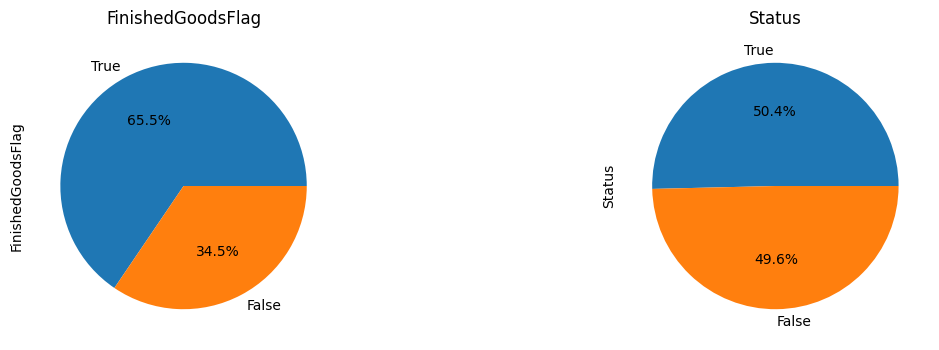

In [73]:
#Se crean dos graficos con los datos de FinishedGoodsFlag y Status
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
ax = products['FinishedGoodsFlag'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0])
ax.set_title('FinishedGoodsFlag')
ax=products_true['Status'].isnull().value_counts().plot.pie(autopct='%1.1f%%', ax=axes[1])
ax.set_title('Status')




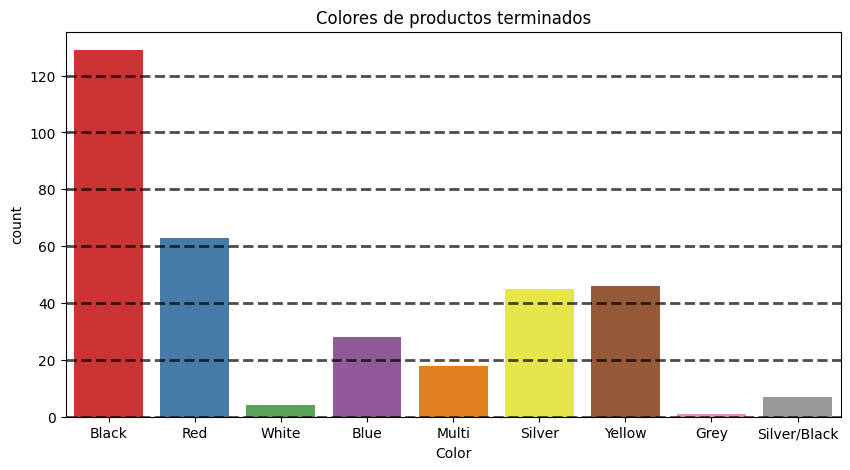

In [74]:
plt.figure(figsize=(10,5))
sns.countplot(x='Color',data=products_true,palette='Set1')
plt.title('Colores de productos terminados')
plt.grid(color='black', linestyle='--',linewidth=2, axis='y', alpha=0.7)
plt.show()

In [75]:
#conteo de datos distintos de todas las columnas de la tabla products
products_clean_1.info()
products_clean_1.iloc[:,18:21].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606 entries, 0 to 605
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ProductKey             606 non-null    int64  
 1   ProductAlternateKey    606 non-null    object 
 2   ProductSubcategoryKey  397 non-null    float64
 3   EnglishProductName     606 non-null    object 
 4   StandardCost           395 non-null    float64
 5   FinishedGoodsFlag      606 non-null    bool   
 6   Color                  352 non-null    object 
 7   SafetyStockLevel       606 non-null    int64  
 8   ReorderPoint           606 non-null    int64  
 9   ListPrice              395 non-null    float64
 10  Weight                 282 non-null    float64
 11  DaysToManufacture      606 non-null    int64  
 12  ProductLine            380 non-null    object 
 13  DealerPrice            395 non-null    float64
 14  Class                  330 non-null    object 
 15  Style 

In [76]:
#Creamos un csv con los datos limpios
#products_clean_1.to_csv('/workspaces/Database-project/data/cleaned/Products_Clean_E.csv', index=False)